# FRMOD basics - 1

Import numpy and the necessary modules from the frmod package.  
Set the random seed to get similar results for every run.

In [2]:
import numpy as np
from frmod.analysis import VRaster, LandslideMask, FRAnalysis, show_grid

np.random.seed(42)

**Read input data and create the VRaster and LandslideMask objects.**  
VRaster objects store the data related to the analyzed layers (eg. elevation, slope). You have to specify four arguments to create a VRaster for the analysis:  
- **name** : The name of the VRaster. Eg. *'elevation'*
- **path** : Path to the raster grid of the layer. All rasters used in the analysis must be in the same grid system (resolution, cellsize, projection). The layer must be compatible with GDAL, but this should not be an issue for most of the common raster formats. Eg. *'./data/layer.sdat'*
- **bins** : The data will be sorted into this many equal-width categories for the analysis. Eg. *10* 
- **categorical** : Set it True if the layer is categorical and set it False if the layer is not categorical. Eg. *True*
  
LandslideMask objects store the data for the mask. The mask is used to separate the landslide and the non-landslide areas. 

In [3]:
elevation = VRaster(name='elevation',
                    path='./data/SRTM31_EG_GF_m.sdat',
                    bins=15,
                    categorical=False)
slope = VRaster(name='slope',
                path='./data/SRTM31_EG_GF_Slope_m.sdat',
                bins=15,
                categorical=False)
geology = VRaster(name='geology_14',
                  path='./data/fdt100_14k.sdat',
                  categorical=True)
scarps = LandslideMask(name='scarps',
                       path='./data/scarps.sdat',
                       ls_marker=1,
                       fold_count=5)

Plot the grid of the elevation VRaster along with its basic statistics.

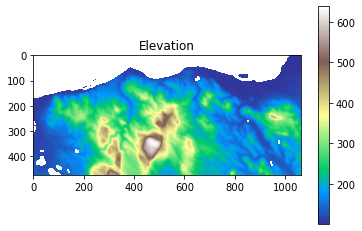

Name: elevation Limits: (100.67122, 638.9841)
Mean: 219.7329864501953 Standard deviation: 95.92752838134766


In [4]:
show_grid(elevation.grid, nodata=elevation.nodata, name='Elevation', cmap='terrain')
elevation.show_info()

In [5]:
np.count_nonzero(scarps.grid==1)

4997

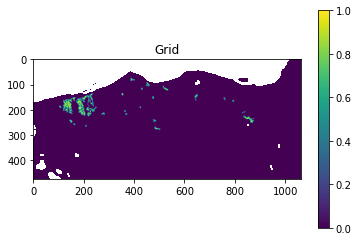

In [6]:
show_grid(scarps.train_areas[0], nodata=scarps.nodata)

Create the FRAnalysis object. Upon instantiation, the frequency ratios are computed for the analyzed layers for each validation fold. 

In [7]:
fra = FRAnalysis(ls_mask=scarps,
                 var_list=[slope,
                           geology,
                           elevation]
                 )

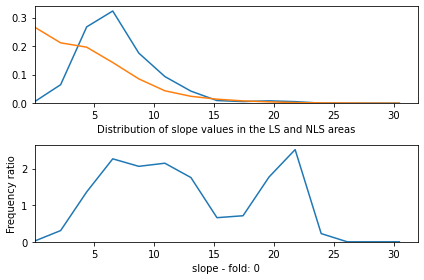

(<Figure size 432x288 with 2 Axes>,
 [<matplotlib.lines.Line2D at 0x284a942b0c8>])

In [9]:
fra.plot_var_fold_fr('slope', 0)

In [10]:
result_percentile_bins = fra.get_result()

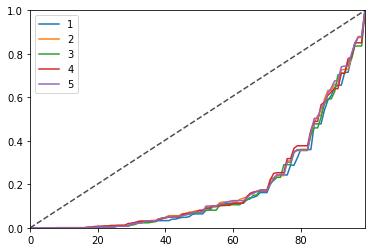

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x284a9387148>)

In [11]:
success_rates = fra.get_src()
fra.plot_success_rates()

In [12]:
auc_folds = fra.get_auc()

Auc: 17.909
Auc: 18.935
Auc: 18.24024024024024
Auc: 18.914914914914917
Auc: 18.930930930930934
Mean score: 18.586017217217215; Std: 0.43054434808816905


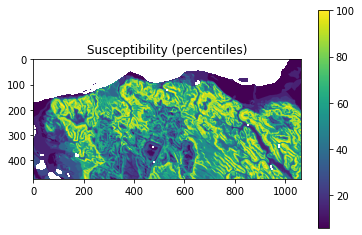

In [13]:
fra.get_percentile_grid(show=True)